# Setup

In [3]:
import copy
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as mplc
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from tqdm import tqdm
import geopandas as gp
import pooch
import regionmask

# Configuration

In [203]:
#Verbose output?
verbose='true'

#Fixes masks on default ocean basin and continents masks. If you load your own, this should be turned off.
maskfixes='true'

#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this 
#would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'


#Define the name and evaluated variables for your model run

cmip6 = {
    'ACCESS-CM2':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'AWI-CM1-MR':   [           'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'BCC-SM2-MR':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CAMS':         [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CanESM5':      [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CAS-ESM2-0':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',                         ],
    'CESM2':        [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst'                ],
    'CIESM':        [           'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'CMCC-CM2-SR5': [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CNRM-CM6-1-HR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst'                ],
    'E3SM-1-1':     [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'EC-Earth3':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'FGOALS-f3-L':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'FIO-ESM-2-0':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'GISS-E2-1-G':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'HadGEM3MM':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'ICON-ESM-LR':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'IITM-ESM':     [           'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',        'tos',                         ],
    'INM5':         [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',                         'thetao', 'so'],
    'IPSL-CM6A-LR': [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'KIOST-ESM':    [ 'siconc', 'tas', 'clt',       'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst',               ],
    'MCMUA1':       [           'tas',        'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',        'tos',           'thetao', 'so'],
    'MIROC6':       [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',                         ],
    'MPI-ESM1-2-HR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'MRI-ESM2-0':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas',             'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'NESM3':        [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],   
    'NOAA-GFDL':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'NorESM2-MM':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'SNU':          [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'TaiESM1':      [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
}

ece3= {    
    'EC-Earth3':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
}

awi_cm3_v31= {
    'AWI-CM3-v3.1':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
}
access_cm2= {
    'ACCESS-CM2':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
}

models = ece3

eval_models = cmip6


# Setup variables (turn off variables for analysis by instancing with optional argument active=False)
class var:
    def __init__ (self, name, obs, depths, domain='mixed', active=True):
        self.name = name
        self.obs = obs
        self.depths = depths
        self.domain = domain
        self.active = active
        
siconc = var(name='siconc',obs='OSISAF', depths=['surface'], domain='oce')
pr = var(name='pr', obs='GPCP', depths=['surface'])
tas = var(name='tas', obs=reanalysis, depths=['surface'])
clt = var(name='clt', obs='MODIS', depths=['surface'])
rlut = var(name='rlut', obs='CERES', depths=['surface'])
uas = var(name='uas', obs=reanalysis, depths=['surface'])
vas = var(name='vas', obs=reanalysis, depths=['surface'])
ua = var(name='ua', obs=reanalysis, depths=['300hPa'])
zg = var(name='zg', obs=reanalysis, depths=['500hPa'])
zos = var(name='zos', obs='NESDIS', depths=['surface'])
tos = var(name='tos', obs='HadISST2', depths=['surface'])
mlotst = var(name='mlotst', obs='C-GLORSv7', depths=['surface'])
thetao = var(name='thetao', obs='C-GLORSv7', depths=['10m','100m','1000m'])
so = var(name='so', obs='C-GLORSv7', depths=['10m','100m','1000m'])


#Select regions 
class region:
    def __init__ (self, name, domain, active=False):
        self.name = name
        self.domain = domain
        self.active = active
        
glob = regions(name='glob', domain='mixed')
arctic =  regions(name='arctic', domain='mixed')
Atlantic_Basin =  regions(name='Atlantic_Basin', domain='ocean')
Asia =  regions(name='Asia', domain='land')

complexity = 'regions'

if complexity == 'boxes':
    regions_select = ['glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 'southmid', 'antarctic']
elif complexity == 'regions':
    regions_select = ['Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Arctic_Basin', 'Southern_Ocean_Basin', 
                      'Mediterranean_Basin', 'Asia', 'North_America', 'Europe', 'Africa', 'South_America', 
                      'Oceania', 'Australia', 'Antarctica']
else:
    regions_select = ['Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Arctic_Basin', 'Southern_Ocean_Basin', 
                      'Mediterranean_Basin', 'Asia', 'North_America', 'Europe', 'Africa', 'South_America', 'Oceania', 
                      'Australia', 'Antarctica','glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 
                      'southmid', 'antarctic']

        
#Select seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

NameError: name 'true' is not defined

# Dataloading

In [131]:
# Retrieve Polygons; Read them; Interpolate to 2° x 2° masks; Concat into one DataArray 
file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)
ocean_basins = gp.read_file("geojson/ocean_basins.geojson")

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 2)
continents_masks = regionmask.mask_3D_geopandas(continents, lon, lat)
ocean_basins_masks = regionmask.mask_3D_geopandas(ocean_basins, lon, lat)

ocean_basins_masks['region'==1]
ocean_basins_masks['region']=ocean_basins_masks.region+continents_masks.sizes['region']


In [132]:
# Add simple box masks

#Define regions
boxes={
    'glob' : {
    'lat_min':-90,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'none',},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'red',},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'lightgrey',},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
        
    'nino34' : {
    'lat_min':-5,
    'lat_max':5,
    'lon_min':190,
    'lon_max':240,
    'plot_color':'yellow',},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'blue',},
    
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
          
}

# Create lat & lon filters based on box edges
boxlist=[]
for box in boxes:
    boxlist.append(box)
    
boxnum=[]
mask_lat=OrderedDict()
mask_lat=OrderedDict()
n=0
box_masks_np=np.empty(shape=(len(lat),len(lon),len(boxlist)))
for box in boxes:
    mask_lat=np.logical_and(lat>boxes[box]['lat_min'], lat<boxes[box]['lat_max'])
    mask_lon=np.logical_and(lon>boxes[box]['lon_min'], lon<boxes[box]['lon_max'])
    boxnum.append(n+ocean_basins_masks.sizes['region']+continents_masks.sizes['region']) # offset region number 

    
    # Make numpy array with gridded mask
    for i in range(0,len(lat)):
        for j in range(0,len(lon)):
            box_masks_np[i,j,n]=np.logical_and(mask_lat[i],mask_lon[j])
    n+=1     
    
# Same xarray format as complex ocean and continent masks above.
box_masks = xr.DataArray(box_masks_np, 
coords={'lat': lat,'lon': lon,'region': boxnum}, 
dims=["lat", "lon", "region"])


In [150]:
masks=xr.concat((continents_masks,ocean_basins_masks,box_masks),dim="region")

if maskfixes:
    # Create Southern Ocean mask via xor nearby continental masks 
    save_orig = copy.deepcopy(masks.sel(region=12))
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=4)) #South America
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=5)) #Oceania
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=6)) #Australia
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=7)) #Antarctica
    masks[12,:,:] = np.logical_and(masks.sel(region=12), save_orig)

    # Fix the Arctic and Atlantic bleeding into Greenland
    save_orig = copy.deepcopy(masks.sel(region=8))
    masks[8,:,:] = np.logical_xor(masks.sel(region=8), masks.sel(region=1)) 
    masks[8,:,:] = np.logical_and(masks.sel(region=8), save_orig) 


In [152]:
# Store masks as dictrionary for easy access
regions_avail = OrderedDict()


for i in range(0,continents_masks.sizes['region']):
    if verbose:
        print('Mask available for:',i,continents['CONTINENT'][i].replace(' ', '_'))
    regions_avail[continents['CONTINENT'][i].replace(' ', '_')]={ 
        'mask': masks[i]
    }
for i in range(0,ocean_basins_masks.sizes['region']):
    if verbose:
        print('Mask available for:',i,ocean_basins['name'][i].replace(' ', '_'))
    regions_avail[ocean_basins['name'][i].replace(' ', '_')]={ 
        'mask': masks[i+continents_masks.sizes['region']]
    }
for i in range(boxnum[0],boxnum[len(boxnum)-1]+1):
    if verbose:
        print('Mask available for:',i,boxlist[i-boxnum[0]].replace(' ', '_'))
    regions_avail[boxlist[i-boxnum[0]].replace(' ', '_')]={ 
        'mask': masks[i]
    }
    

# Select subset of available regions
regions = OrderedDict()
for r in regions_select:
    if verbose:
        print('Selecting Mask for:',r)
    regions[r] = regions_avail[r]

Mask available for: 0 Asia
Mask available for: 1 North_America
Mask available for: 2 Europe
Mask available for: 3 Africa
Mask available for: 4 South_America
Mask available for: 5 Oceania
Mask available for: 6 Australia
Mask available for: 7 Antarctica
Mask available for: 0 Atlantic_Basin
Mask available for: 1 Pacific_Basin
Mask available for: 2 Indian_Basin
Mask available for: 3 Arctic_Basin
Mask available for: 4 Southern_Ocean_Basin
Mask available for: 5 Mediterranean_Basin
Mask available for: 14 glob
Mask available for: 15 arctic
Mask available for: 16 northmid
Mask available for: 17 tropics
Mask available for: 18 innertropics
Mask available for: 19 nino34
Mask available for: 20 southmid
Mask available for: 21 antarctic
Selecting Mask for: Asia
Selecting Mask for: North_America
Selecting Mask for: Europe
Selecting Mask for: Africa
Selecting Mask for: South_America
Selecting Mask for: Oceania
Selecting Mask for: Australia
Selecting Mask for: Antarctica


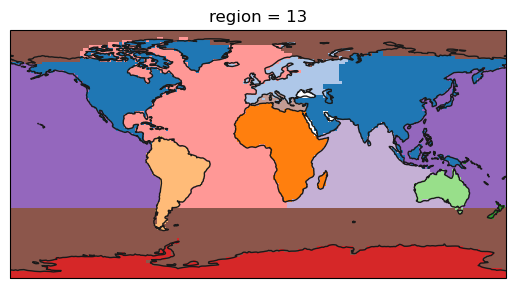

In [151]:
cm = plt.get_cmap('tab20')
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
for i in range(0,ocean_basins_masks.sizes['region']+continents_masks.sizes['region']):
    cmap = mplc.ListedColormap(['#FFFFFF00', cm(1*i/masks.sizes['region'])])
    masks.sel(region=i).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap=cmap,
    )

ax.coastlines(color="0.1");

In [153]:
print('Loading obs data')

ds_obs = OrderedDict()

for var,depths in zip(obs,var_depths):
    for depth in np.arange(0,len(var_depths[depths])):
        for seas in seasons:
            if verbose == 'true':
                print('loading '+obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')

            intermediate = xr.open_dataset(obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')
            ds_obs[var,var_depths[depths][depth],seas] = intermediate.compute()
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('time_bnds')
            except:
                pass
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('time_bnds_2')
            except:
                pass
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('depth')
            except:
                pass
            

Loading obs data
loading obs/siconc_OSISAF_surface_MAM.nc
loading obs/siconc_OSISAF_surface_JJA.nc
loading obs/siconc_OSISAF_surface_SON.nc
loading obs/siconc_OSISAF_surface_DJF.nc
loading obs/tas_ERA5_surface_MAM.nc
loading obs/tas_ERA5_surface_JJA.nc
loading obs/tas_ERA5_surface_SON.nc
loading obs/tas_ERA5_surface_DJF.nc
loading obs/clt_MODIS_surface_MAM.nc
loading obs/clt_MODIS_surface_JJA.nc
loading obs/clt_MODIS_surface_SON.nc
loading obs/clt_MODIS_surface_DJF.nc
loading obs/pr_GPCP_surface_MAM.nc
loading obs/pr_GPCP_surface_JJA.nc
loading obs/pr_GPCP_surface_SON.nc
loading obs/pr_GPCP_surface_DJF.nc
loading obs/rlut_CERES_surface_MAM.nc
loading obs/rlut_CERES_surface_JJA.nc
loading obs/rlut_CERES_surface_SON.nc
loading obs/rlut_CERES_surface_DJF.nc
loading obs/uas_ERA5_surface_MAM.nc
loading obs/uas_ERA5_surface_JJA.nc
loading obs/uas_ERA5_surface_SON.nc
loading obs/uas_ERA5_surface_DJF.nc
loading obs/vas_ERA5_surface_MAM.nc
loading obs/vas_ERA5_surface_JJA.nc
loading obs/vas_ERA

In [154]:
print('Loading model data')

ds_model = OrderedDict()

for model in tqdm(models):
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for seas in seasons:
                if verbose == 'true':
                    print('loading '+model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = xr.open_mfdataset(model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = intermediate.squeeze(drop=True)
                ds_model[var,var_depths[var][depth],seas,model] = intermediate.compute()
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('time_bnds')
                except:
                    pass
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('depth')
                except:
                    pass


Loading model data


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/softwa

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_DJF.nc


# CMIP calcluations

In [155]:
print('Calculating absolute error and field mean of abs error')

# Returns equvalent to cdo fldmean ()
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))


abs_error = OrderedDict()
mean_error = OrderedDict()

for model in tqdm(models):
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                for seas in seasons:
                    abs_error[var,var_depths[var][depth],seas,model,region]=np.sqrt((ds_model[var,var_depths[var][depth],seas,model].where(regions[region]['mask'])-
                                                       ds_obs[var,var_depths[var][depth],seas]).where(regions[region]['mask'])*
                                                      (ds_model[var,var_depths[var][depth],seas,model].where(regions[region]['mask'])-
                                                       ds_obs[var,var_depths[var][depth],seas].where(regions[region]['mask'])))
                    mean_error[var,var_depths[var][depth],seas,model,region] = fldmean(abs_error[var,var_depths[var][depth],seas,model,region])


Calculating absolute error and field mean of abs error


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


In [156]:
print('Writing field mean of errors into csv files')

for model in tqdm(models):
    with open(out_path+'abs/'+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                for depth in np.arange(0,len(var_depths[var])):
                    for seas in seasons:
                        print(seas, depth, region, var, model)
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(mean_error[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])

Writing field mean of errors into csv files


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

MAM 0 Asia siconc EC-Earth3
JJA 0 Asia siconc EC-Earth3
SON 0 Asia siconc EC-Earth3
DJF 0 Asia siconc EC-Earth3
MAM 0 North_America siconc EC-Earth3
JJA 0 North_America siconc EC-Earth3
SON 0 North_America siconc EC-Earth3
DJF 0 North_America siconc EC-Earth3
MAM 0 Europe siconc EC-Earth3
JJA 0 Europe siconc EC-Earth3
SON 0 Europe siconc EC-Earth3
DJF 0 Europe siconc EC-Earth3
MAM 0 Africa siconc EC-Earth3
JJA 0 Africa siconc EC-Earth3
SON 0 Africa siconc EC-Earth3
DJF 0 Africa siconc EC-Earth3
MAM 0 South_America siconc EC-Earth3
JJA 0 South_America siconc EC-Earth3
SON 0 South_America siconc EC-Earth3
DJF 0 South_America siconc EC-Earth3
MAM 0 Oceania siconc EC-Earth3
JJA 0 Oceania siconc EC-Earth3
SON 0 Oceania siconc EC-Earth3
DJF 0 Oceania siconc EC-Earth3
MAM 0 Australia siconc EC-Earth3
JJA 0 Australia siconc EC-Earth3
SON 0 Australia siconc EC-Earth3
DJF 0 Australia siconc EC-Earth3
MAM 0 Antarctica siconc EC-Earth3
JJA 0 Antarctica siconc EC-Earth3
SON 0 Antarctica siconc EC-E

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


In [157]:
print('Reading precalculated cmip6 field mean of errors from csv files')

max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

collect = np.empty([len(eval_models),len(obs),len(regions),max_depth,len(seasons)])*np.nan
i=0
for eval_model in tqdm(eval_models):
    df = pd.read_csv(eval_path+eval_model+'.csv', delimiter=' ')
    values = df['AbsMeanError']
    regions_csv = df['Region']
    var_csv = df['Variable']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',eval_model,var)
            else:
                print('filling: ',eval_model,var)
        for region in regions:
            l=0
            for depth in np.arange(0,len(var_depths[var])):
                m=0
                for seas in seasons:
                    if any(a): # Check if variable appears in csv. If not, skip it.
                        if regions_csv[r] not in regions: # Check if region from csv part of the analysis. Else advance
                            while True:
                                r+=1
                                if regions_csv[r] in regions:
                                    break
                        collect[i,j,k,l,m]=values[r]
                        r+=1
                    m+=1
                l+=1
            k+=1
        j+=1
    i+=1
# Ignoring non useful warning:
# /tmp/ipykernel_19478/363568120.py:37: RuntimeWarning: Mean of empty slice
#  ensmean=np.nanmean(collect,axis=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensmean=np.nanmean(collect,axis=0)


Reading precalculated cmip6 field mean of errors from csv files


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
filling:  AWI-CM1-MR siconc
reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
reading:  BCC-SM2-MR siconc
reading:  BCC-SM2-MR tas
reading:  BCC-SM2-MR clt
reading:  BCC-SM2-MR pr
reading:  BCC-SM2-MR rlut
reading:  BCC-SM2-MR uas
reading:  BCC-SM2-MR vas
reading:  BCC-SM2-MR ua
reading:  BCC-SM2-MR zg
reading:  BCC-SM2-MR zos
reading:  BCC-SM2-MR tos


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:00<00:00, 86.19it/s]

reading:  BCC-SM2-MR mlotst
reading:  BCC-SM2-MR thetao
reading:  BCC-SM2-MR so
reading:  CAMS siconc
reading:  CAMS tas
reading:  CAMS clt
reading:  CAMS pr
reading:  CAMS rlut
reading:  CAMS uas
reading:  CAMS vas
reading:  CAMS ua
reading:  CAMS zg
reading:  CAMS zos
reading:  CAMS tos
reading:  CAMS mlotst
reading:  CAMS thetao
reading:  CAMS so
reading:  CanESM5 siconc
reading:  CanESM5 tas
reading:  CanESM5 clt
reading:  CanESM5 pr
reading:  CanESM5 rlut
reading:  CanESM5 uas
reading:  CanESM5 vas
reading:  CanESM5 ua
reading:  CanESM5 zg
reading:  CanESM5 zos
reading:  CanESM5 tos
reading:  CanESM5 mlotst
reading:  CanESM5 thetao
reading:  CanESM5 so
reading:  CAS-ESM2-0 siconc
reading:  CAS-ESM2-0 tas
reading:  CAS-ESM2-0 clt
reading:  CAS-ESM2-0 pr
reading:  CAS-ESM2-0 rlut
reading:  CAS-ESM2-0 uas
reading:  CAS-ESM2-0 vas
reading:  CAS-ESM2-0 ua
reading:  CAS-ESM2-0 zg
reading:  CAS-ESM2-0 zos
reading:  CAS-ESM2-0 tos
filling:  CAS-ESM2-0 mlotst
filling:  CAS-ESM2-0 thetao
fi

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:00<00:00, 93.60it/s]

reading:  KIOST-ESM siconc
reading:  KIOST-ESM tas
reading:  KIOST-ESM clt
filling:  KIOST-ESM pr
reading:  KIOST-ESM rlut
reading:  KIOST-ESM uas
reading:  KIOST-ESM vas
reading:  KIOST-ESM ua
reading:  KIOST-ESM zg
reading:  KIOST-ESM zos
reading:  KIOST-ESM tos
reading:  KIOST-ESM mlotst
filling:  KIOST-ESM thetao
filling:  KIOST-ESM so
filling:  MCMUA1 siconc
reading:  MCMUA1 tas
filling:  MCMUA1 clt
reading:  MCMUA1 pr
reading:  MCMUA1 rlut
reading:  MCMUA1 uas
reading:  MCMUA1 vas
reading:  MCMUA1 ua
reading:  MCMUA1 zg
filling:  MCMUA1 zos
reading:  MCMUA1 tos
filling:  MCMUA1 mlotst
reading:  MCMUA1 thetao
reading:  MCMUA1 so
reading:  MIROC6 siconc
reading:  MIROC6 tas
reading:  MIROC6 clt
reading:  MIROC6 pr
reading:  MIROC6 rlut
reading:  MIROC6 uas
reading:  MIROC6 vas
reading:  MIROC6 ua
reading:  MIROC6 zg
reading:  MIROC6 zos
reading:  MIROC6 tos
filling:  MIROC6 mlotst
filling:  MIROC6 thetao
filling:  MIROC6 so
reading:  MPI-ESM1-2-HR siconc
reading:  MPI-ESM1-2-HR tas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.58it/s]

reading:  MRI-ESM2-0 siconc
reading:  MRI-ESM2-0 tas
reading:  MRI-ESM2-0 clt
reading:  MRI-ESM2-0 pr
reading:  MRI-ESM2-0 rlut
reading:  MRI-ESM2-0 uas
reading:  MRI-ESM2-0 vas
filling:  MRI-ESM2-0 ua
filling:  MRI-ESM2-0 zg
reading:  MRI-ESM2-0 zos
reading:  MRI-ESM2-0 tos
reading:  MRI-ESM2-0 mlotst
reading:  MRI-ESM2-0 thetao
reading:  MRI-ESM2-0 so
reading:  NESM3 siconc
reading:  NESM3 tas
reading:  NESM3 clt
reading:  NESM3 pr
reading:  NESM3 rlut
reading:  NESM3 uas
reading:  NESM3 vas
reading:  NESM3 ua
reading:  NESM3 zg
reading:  NESM3 zos
reading:  NESM3 tos
reading:  NESM3 mlotst
reading:  NESM3 thetao
reading:  NESM3 so
reading:  NOAA-GFDL siconc
reading:  NOAA-GFDL tas
reading:  NOAA-GFDL clt
reading:  NOAA-GFDL pr
reading:  NOAA-GFDL rlut
reading:  NOAA-GFDL uas
reading:  NOAA-GFDL vas
reading:  NOAA-GFDL ua
reading:  NOAA-GFDL zg
reading:  NOAA-GFDL zos
reading:  NOAA-GFDL tos
filling:  NOAA-GFDL mlotst
reading:  NOAA-GFDL thetao
reading:  NOAA-GFDL so
reading:  NorESM

In [158]:
print('Placing sums of error into easier to inspect dictionary')

eval_error_mean = OrderedDict()

j=0
for var in tqdm(obs):
    k=0
    for region in regions:
        l=0
        for depth in np.arange(0,len(var_depths[var])):
            m=0
            for seas in seasons:
                eval_error_mean[var,region,var_depths[var][depth],seas]=ensmean[j,k,l,m]
                m+=1
            l+=1
        k+=1
    j+=1

Placing sums of error into easier to inspect dictionary


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22267.83it/s]


In [159]:
print('Calculating ratio of current model error to evaluation model error')

error_fraction = OrderedDict()

sum=0
for model in tqdm(models):
    for var in models[model]:
        for region in regions:
            for depth in np.arange(0,len(var_depths[var])):
                for seas in seasons:
                    error_fraction[var,var_depths[var][depth],seas,model,region] = mean_error[var,var_depths[var][depth],seas,model,region] / eval_error_mean[var,region,var_depths[var][depth],seas]


Calculating ratio of current model error to evaluation model error


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


In [160]:
print('Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score')

cmpi = OrderedDict()

for model in tqdm(models):
    sum=0
    iter=0
    with open(out_path+'frac/'+model+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','FracMeanError'])
        for var in models[model]:
            for depth in np.arange(0,len(var_depths[var])):
                for region in regions:
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])
                        if np.isnan(np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])):
                            pass
                        else:
                            sum+=np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])
                            iter+=1
        cmpi[model]=np.squeeze(sum)/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model]])

Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


# Plotting

Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

reading:  EC-Earth3 siconc
reading:  EC-Earth3 tas
reading:  EC-Earth3 clt
reading:  EC-Earth3 pr
reading:  EC-Earth3 rlut
reading:  EC-Earth3 uas
reading:  EC-Earth3 vas
reading:  EC-Earth3 ua
reading:  EC-Earth3 zg
reading:  EC-Earth3 zos
reading:  EC-Earth3 tos
reading:  EC-Earth3 mlotst
reading:  EC-Earth3 thetao
reading:  EC-Earth3 so
EC-Earth3 number of values:  576 ; shape: 18 x 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


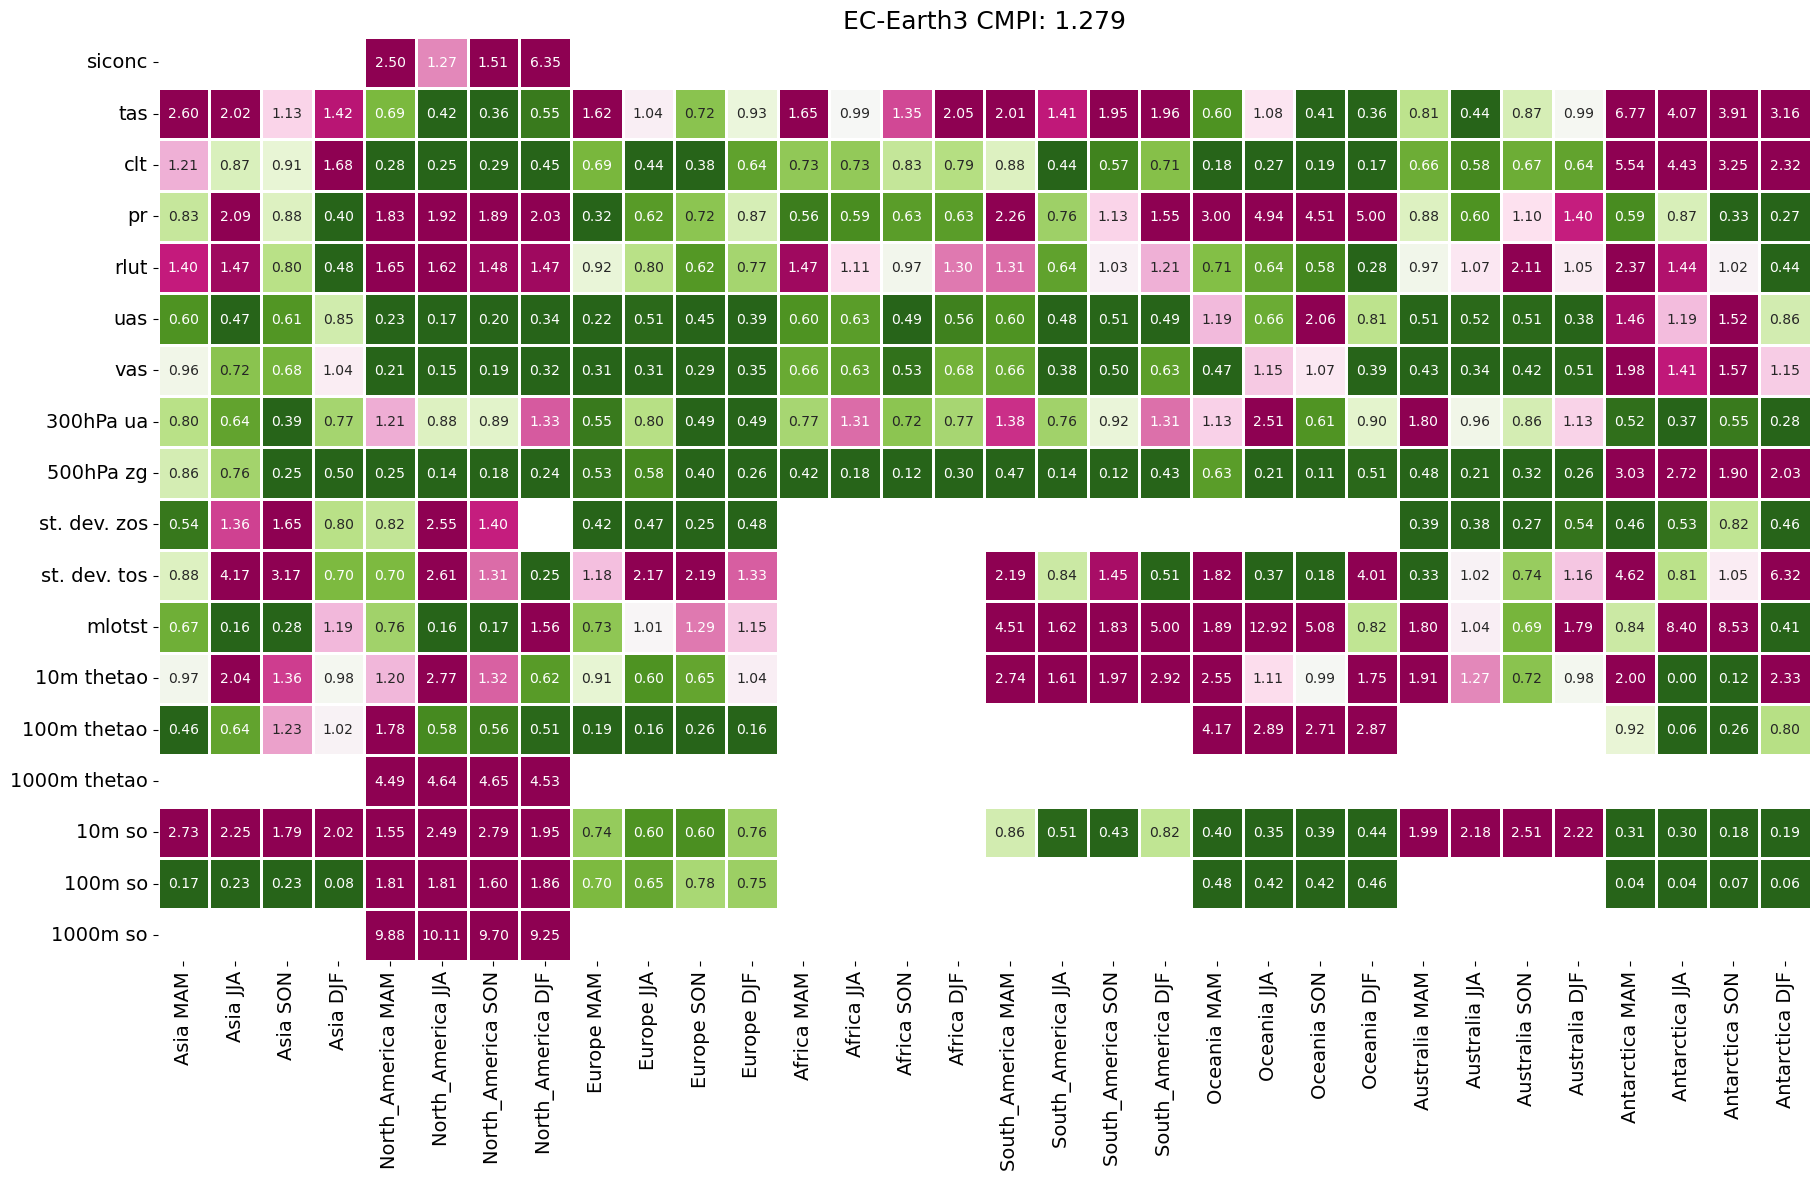

In [161]:
print('Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)')

max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

plt.rcParams.update({'figure.max_open_warning': 0})
collect_frac_non = OrderedDict()
for model in tqdm(models):
    df = pd.read_csv(out_path+'frac/'+model+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    r=0
    for var in obs:
        a=(df['Variable']==var).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',model,var)
            else:
                print('filling: ',model,var)
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                for seas in seasons:
                    if any(a):
                        collect_frac_non[var+' '+region,var_depths[var][depth]+' '+seas]=values[r]
                        r+=1
                    else:
                        collect_frac_non[var+' '+region,var_depths[var][depth]+' '+seas]=np.nan


    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    
    index_obs=[]
    for var in obs:
        for depth in np.arange(0,len(var_depths[var])):
            if var_depths[var][depth] == 'surface':
                levelname=''
            else:
                levelname=var_depths[var][depth]+' '
            if var == 'zos' or var == 'tos':
                levelname='st. dev. '
            index_obs.append(levelname+var)
    if verbose == 'true':
        print(model,'number of values: ',len(list(collect_frac_non.values())),'; shape:',len(index_obs),'x',len(regions)*len(seasons))
    collect_frac_reshaped = np.array(list(collect_frac_non.values()) ).reshape(len(index_obs),len(regions)*len(seasons)) # transform to 2D
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=index_obs, columns=coord)

    fig, ax = plt.subplots(figsize=((len(regions)*len(seasons))/1.5,len(index_obs)/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model+' CMPI: '+str(round(cmpi[model],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model+'.png',dpi=300,bbox_inches='tight')
    i+=1


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]/p/project/chhb19/jstreffi/software/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:15<00:00,  4.50s/it]


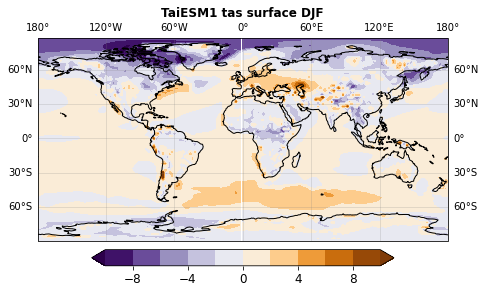

In [72]:
# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

for model in tqdm(models):
    for seas in seasons:
        depth=0
        levels=np.linspace(-10,10,11)
        #levels=np.linspace(-0,2000,11)
        var='clt'

        %matplotlib inline

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
        ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,zorder=3)


        data = ds_model[var,var_depths[var][depth],seas,model].to_array(var).values[0]
        obsp = np.squeeze(ds_obs[var,var_depths[var][depth],seas].to_array(var).values[0])
        #data_to_plot = data[0:90,:]-obsp[0:90,:]
        data_to_plot = obsp[0:90,:]

        lon = np.arange(0, 360, 2)
        lat = np.arange(-90, 90, 2)

        imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

        ax.set_title(model+' '+var+' '+var_depths[var][depth]+' '+seas,fontweight="bold")
        plt.tight_layout() 
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

        gl.xlabels_bottom = False    
        cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
        cbar_ax_abs.tick_params(labelsize=12)
        cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
        cb.ax.tick_params(labelsize='12')
        plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')


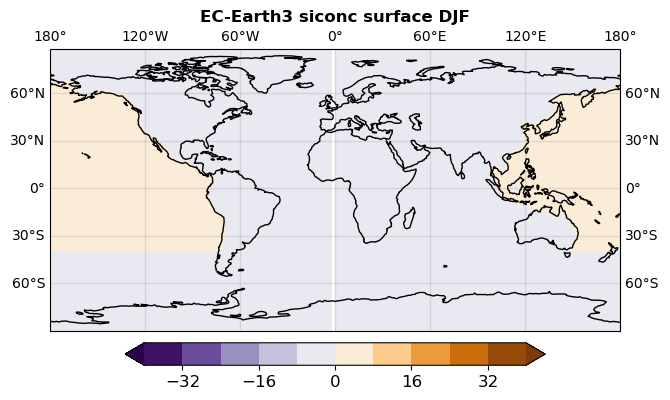

In [165]:



# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

model="EC-Earth3"

for seas in seasons:
    depth=0
    levels=np.linspace(-40,40,11)
    #levels=np.linspace(-0,2000,11)
    var='siconc'

    %matplotlib inline

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,zorder=3)


    #data = np.squeeze(regions['Africa']['mask'])
    data = masks[9,:,:]

    #data_to_plot = data[0:90,:]-obsp[0:90,:]
    data_to_plot = data[0:90,:]

    lon = np.arange(0, 360, 2)
    lat = np.arange(-90, 90, 2)

    imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

    ax.set_title(model+' '+var+' '+var_depths[var][depth]+' '+seas,fontweight="bold")
    plt.tight_layout() 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
    cb.ax.tick_params(labelsize='12')
    plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')

In [ ]:
Mask available for: 0 Asia
Mask available for: 1 North_America
Mask available for: 2 Europe
Mask available for: 3 Africa
Mask available for: 4 South_America
Mask available for: 5 Oceania
Mask available for: 6 Australia
Mask available for: 7 Antarctica
Mask available for: 0 Atlantic_Basin
Mask available for: 1 Pacific_Basin
Mask available for: 2 Indian_Basin
Mask available for: 3 Arctic_Basin
Mask available for: 4 Southern_Ocean_Basin
Mask available for: 5 Mediterranean_Basin
Mask available for: 14 glob
Mask available for: 15 arctic
Mask available for: 16 northmid
Mask available for: 17 tropics
Mask available for: 18 innertropics
Mask available for: 19 nino34
Mask available for: 20 southmid
Mask available for: 21 antarctic